In [1]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from models import RNNGC, FFGC
from dataset import DatasetMaker
from plotting_functions import multiimshow

In [2]:
# use for both; sets FF size too
samples = 50000
res = 64

timesteps = 50


dataset = DatasetMaker(box_size=1e6)
r, v = dataset.generate_data(samples, timesteps)

if inside := True:
    r0 = torch.rand(size = (samples, 2))*4*np.pi - 2*np.pi
else:
    r0 = torch.rand(size = (samples, 2))*8*np.pi - 4*np.pi

r = r - r[:,0,None] + r0[:,None] # shift to zero ,move to random locations in box
lim = np.amax(np.abs(r.numpy()))


if trajectories := False:
    start = -2
    stop = -1
    model = RNNGC()
    model = model.load("./saved-models/RNNGC_49999.pkl")
    model_type = "RNN"
    g = model((r[:,0], v)) #
    r = r.detach().numpy()[:,start:stop]
    g = g.detach().numpy()[:,start:stop]
    ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = res)[0]
else:
    model = FFGC()
    model_type = "FF"
    model = model.load("./saved-models/FFGC_100000.pkl")
    x = np.linspace(-lim, lim, res)
    y = np.copy(x)
    xx, yy = np.meshgrid(x,y)
    r = np.stack((xx.ravel(), yy.ravel()), axis =-1)
    g = model(torch.tensor(r.astype("float32"))).detach().numpy()
    print(g.shape)
    ratemaps = g.reshape(res, res, -1).T

model.alpha, model.sigma

(4096, 256)


(0.54, 1.2)

In [3]:
if trajectories:
    for i in range(1000):
        plt.plot(r[i,:,0], r[i,:,1])
    plt.axis("equal")

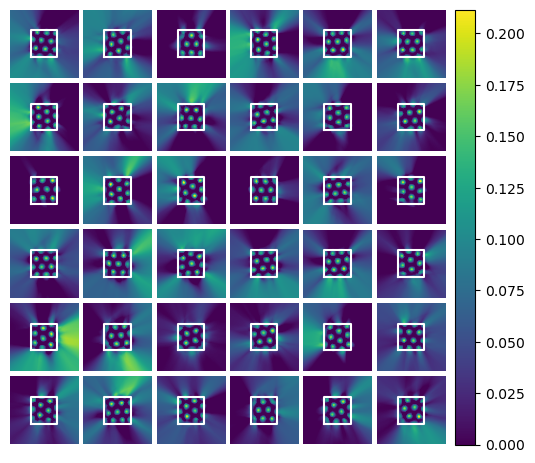

In [5]:
fig, axs, range = multiimshow(ratemaps[:36], figsize = (5,5), extent = [-lim, lim, -lim, lim]);
for ax in axs:
    ax.plot(np.array([-1,-1, 1, 1, -1])*2*np.pi, np.array([-1, 1, 1, -1, -1])*2*np.pi, "w")
plt.savefig(f"./figures/{model_type}_inside_{inside}.png")